<a href="https://colab.research.google.com/github/vkthakur90/jupyter_notebooks/blob/master/Laplacian_of_Gaussian_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import google.colab.files as gcf

In [2]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow.keras.models as tfkm
import tensorflow.keras.utils as tfku

In [3]:
(x_train, y_train), (x_test, y_test) = tfk.datasets.cifar10.load_data()

In [4]:
!ls

uploaded = gcf.upload()

for k, v in uploaded.items():
    with open(k, 'wb') as f:
        f.write(v)

!ls

log_autoencoder  log_autoencoder.zip  model.png  sample_data  sid_kiara.jpg


log_autoencoder  log_autoencoder.zip  model.png  sample_data  sid_kiara.jpg


In [5]:
img = tfku.load_img('sid_kiara.jpg', target_size = [480, 640], keep_aspect_ratio = True)
img_arr = tfku.img_to_array(img)

In [6]:
@tfku.register_keras_serializable()
class EmbeddingMemoryLayer(tfkl.Layer):
    def __init__(self, num_keys):
        super().__init__()
        self.num_keys = num_keys

    def get_config(self):
        config = super().get_config()
        config.update({
            'num_keys': self.num_keys
        })

        return config

    def build(self, input_shape):
        self.keys = self.add_weight(name = 'keys', shape = [self.num_keys, input_shape[-1]], dtype = tf.float32, initializer = 'glorot_uniform')

    def call(self, input):
        k = tf.cast(self.num_keys, dtype = tf.float32)
        score = tf.matmul(input, self.keys, transpose_b = True)/tf.sqrt(k)
        attn = tf.math.softmax(score, axis = -1)
        out = tf.matmul(attn, self.keys)

        return out

In [7]:
@tfku.register_keras_serializable()
class ResidualBlock(tfkl.Layer):
    def __init__(self, hidden_units):
        super().__init__()
        self.hidden_units = hidden_units

    def get_config(self):
        config = super().get_config()
        config.update({
            'hidden_units' : self.hidden_units
        })

        return config

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])

        x = inp
        x = EmbeddingMemoryLayer(self.hidden_units)(x)
        x = tfkl.Add()([x, inp])
        out = x

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [8]:
@tfku.register_keras_serializable()
class UniformConv(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])
        filter_layer = tfkl.DepthwiseConv2D((3, 3), use_bias = False, padding = 'same')

        filter_array = np.array([
            [1/9, 1/9, 1/9],
            [1/9, 1/9, 1/9],
            [1/9, 1/9, 1/9]
        ])[..., np.newaxis, np.newaxis]


        x = inp
        x = tfkl.Lambda(lambda t: tf.split(t, num_or_size_splits = input_shape[-1], axis = -1))(x)
        x = [filter_layer(t) for t in x]
        x = tfkl.Concatenate(axis = -1)(x)

        out = x

        filter_layer.set_weights([filter_array])

        filter_layer.trainable = False

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [9]:
@tfku.register_keras_serializable()
class GaussianConv(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])
        gaussian = tfkl.DepthwiseConv2D((3, 3), use_bias = False, padding = 'same')

        gaussian_filter = np.array([
            [1/16, 2/16, 1/16],
            [2/16, 4/16, 2/16],
            [1/16, 2/16, 1/16]
        ])[..., np.newaxis, np.newaxis]


        x = inp
        x = tfkl.Lambda(lambda t: tf.split(t, num_or_size_splits = input_shape[-1], axis = -1))(x)
        x = [gaussian(t) for t in x]
        x = tfkl.Concatenate(axis = -1)(x)

        out = x

        gaussian.set_weights([gaussian_filter])

        gaussian.trainable = False

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [10]:
@tfku.register_keras_serializable()
class LaplacianConv(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])
        laplacian = tfkl.DepthwiseConv2D((3, 3), use_bias = False, padding = 'same')

        laplacian_filter = np.array([
            [ 0.0, -1.0,  0.0],
            [-1.0,  4.0, -1.0],
            [ 0.0, -1.0,  0.0]
        ])[..., np.newaxis, np.newaxis]

        x = inp
        x = tfkl.Lambda(lambda t: tf.split(t, num_or_size_splits = input_shape[-1], axis = -1))(x)
        x = [laplacian(t) for t in x]
        x = tfkl.Concatenate(axis = -1)(x)

        out = x

        laplacian.set_weights([laplacian_filter])

        laplacian.trainable = False


        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [11]:
@tfku.register_keras_serializable()
class DownPoolLayer(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])

        x = inp

        z1 = tfkl.MaxPool2D((2, 2))(x)
        z2 = tfkl.Lambda(lambda t: -t)(x)
        z2 = tfkl.MaxPool2D((2, 2))(z2)
        z2 = tfkl.Lambda(lambda t: -t)(z2)
        y = tfkl.Concatenate(axis = -1)([z1, z2])

        out = y

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [12]:
@tfku.register_keras_serializable()
class EdgeDetectionLayer(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])

        x = inp

        x = GaussianConv()(x)
        x = LaplacianConv()(x)
        x = tfkl.ReLU()(x)
        x = UniformConv()(x)


        out = x

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [13]:
@tfku.register_keras_serializable()
class PyramidConvFeatures(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])

        x = inp
        x = tfkl.Rescaling(scale = 1/127.5, offset = -1)(x)

        y = x
        y = GaussianConv()(y)
        y = LaplacianConv()(y)
        x0 = y


        x = DownPoolLayer()(x)
        x1 = EdgeDetectionLayer()(x)

        x = DownPoolLayer()(x)
        x2 = EdgeDetectionLayer()(x)

        x = DownPoolLayer()(x)
        x3 = EdgeDetectionLayer()(x)

        x = DownPoolLayer()(x)
        x4 = EdgeDetectionLayer()(x)

        x = DownPoolLayer()(x)
        x5 = EdgeDetectionLayer()(x)

        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x5)

        x = tfkl.Concatenate(axis = -1)([x4, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)


        x = tfkl.Concatenate(axis = -1)([x3, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)

        x = tfkl.Concatenate(axis = -1)([x2, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)

        x = tfkl.Concatenate(axis = -1)([x1, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)

        x = tfkl.Concatenate(axis = -1)([x0, x])

        out = x

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [14]:
model = tfkm.Sequential([
    tfkl.InputLayer([480, 640, 3]),
    PyramidConvFeatures(),
    tfkl.BatchNormalization(),
    ResidualBlock(3),
    tfkl.BatchNormalization(),
    tfkl.Dense(3, activation = 'tanh')
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pyramid_conv_features (Pyr  (None, 480, 640, 189)     153       
 amidConvFeatures)                                               
                                                                 
 batch_normalization (Batch  (None, 480, 640, 189)     756       
 Normalization)                                                  
                                                                 
 residual_block (ResidualBl  (None, 480, 640, 189)     567       
 ock)                                                            
                                                                 
 batch_normalization_1 (Bat  (None, 480, 640, 189)     756       
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 480, 640, 3)       5

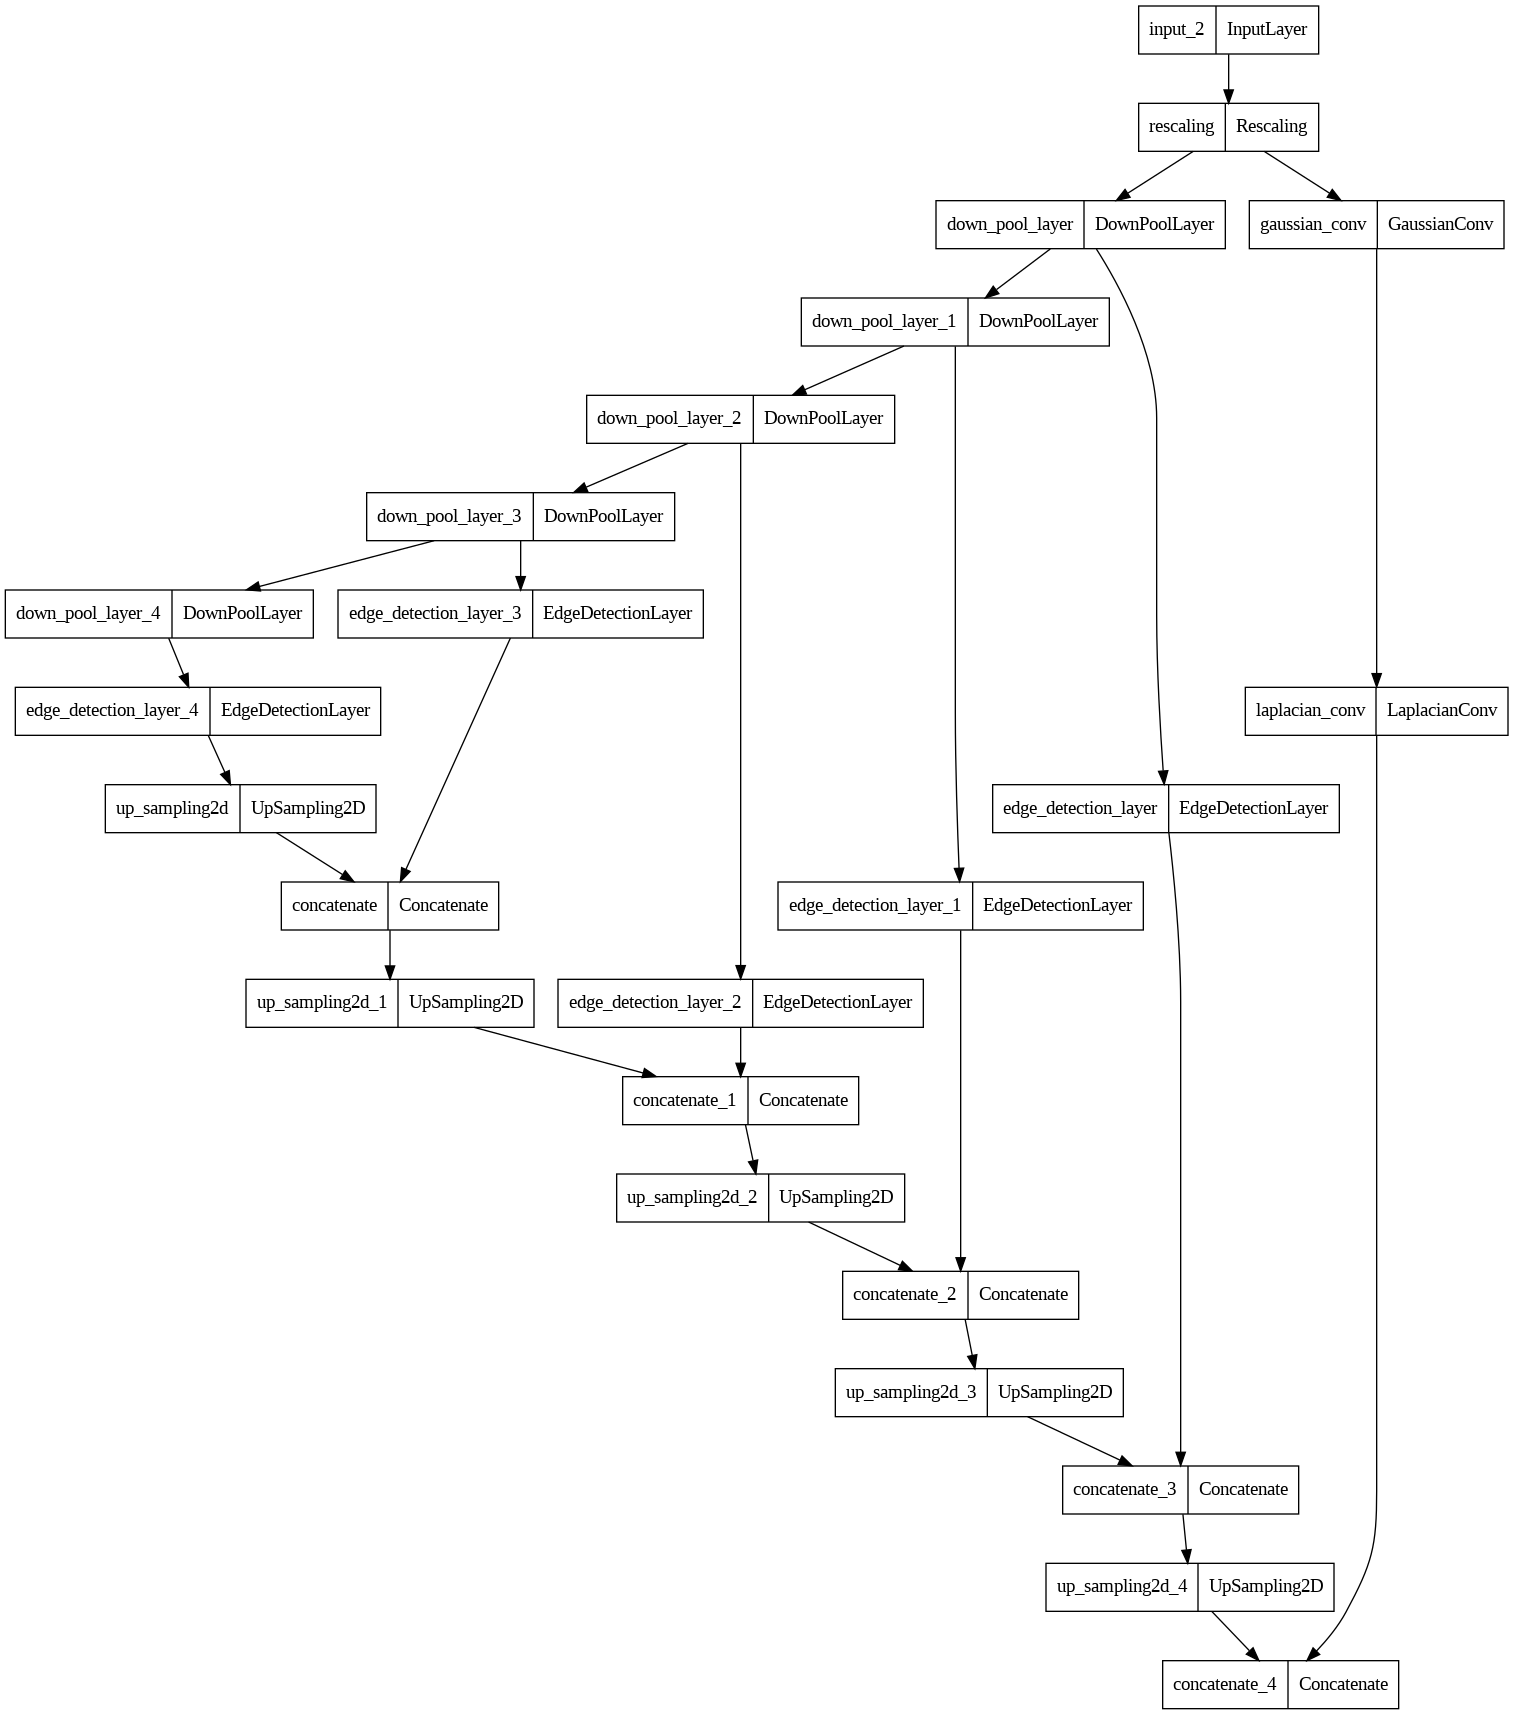

In [16]:
tfku.plot_model(model.layers[0].forward)

In [17]:
train_img = img_arr[np.newaxis, ...]
pred_img = train_img/127.5 - 1

In [18]:
datasets = (
    tf.data.Dataset.from_tensor_slices((train_img, pred_img))
                   .repeat(10000)
                   .batch(8)
)

model.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error'
)

model.fit(datasets)

1250/1250 [==============================] - 784s 616ms/step - loss: 0.0292


In [19]:
pred_x = model.predict(train_img)

norm_pred_x = np.uint8(255.0 * (pred_x - pred_x.min())/ (pred_x.max() - pred_x.min()))



1/1 [==============================] - 3s 3s/step


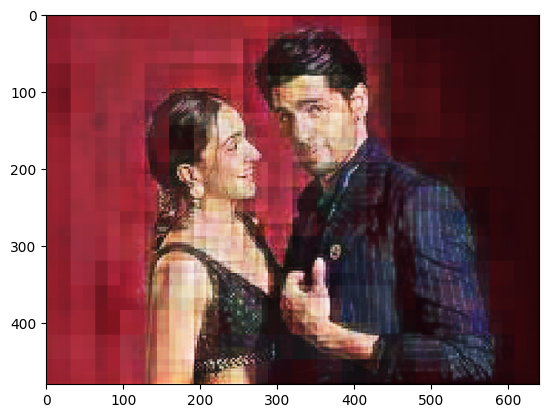

In [20]:
plt.imshow(norm_pred_x[0])

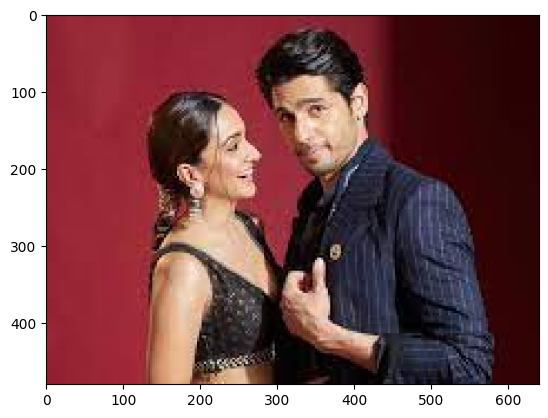

In [21]:
plt.imshow(np.uint8(img_arr))

In [22]:
model.save('log_autoencoder')

In [23]:
!ls log_autoencoder

assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


In [24]:
!zip -r log_autoencoder.zip log_autoencoder

updating: log_autoencoder/ (stored 0%)
updating: log_autoencoder/keras_metadata.pb (deflated 96%)
updating: log_autoencoder/assets/ (stored 0%)
updating: log_autoencoder/fingerprint.pb (stored 0%)
updating: log_autoencoder/variables/ (stored 0%)
updating: log_autoencoder/variables/variables.data-00000-of-00001 (deflated 68%)
updating: log_autoencoder/variables/variables.index (deflated 69%)
updating: log_autoencoder/saved_model.pb (deflated 95%)


In [25]:
#gcf.download('log_autoencoder.zip')